In [1]:
import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm

from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score, confusion_matrix

In [16]:
def generate_toy_data(contamination_rate, radius, seed=None):
    
    noize = 1.0
    
    nb_train = 500
    nb_normal_test = 1000
    nb_anomaly_test = int(nb_normal_test * (contamination_rate/(1-contamination_rate)))
        
    np.random.seed(seed=seed)
    X_train = np.random.multivariate_normal([0,0],[[noize, 0], [0, noize]], nb_train)
    X_test = np.random.multivariate_normal([0,0],[[noize, 0], [0, noize]], nb_normal_test)

    anomaly = np.random.random_sample(nb_anomaly_test) * 2 * np.pi
    
    anomaly_x = np.cos(anomaly) * radius
    anomaly_y = np.sin(anomaly) * radius

    anomaly = np.vstack([anomaly_x, anomaly_y]).T
    anomaly += np.random.normal(scale=0.4, size=anomaly.shape)

    X_test = np.vstack([X_test, anomaly])
    y_test = np.hstack([np.zeros(nb_normal_test, dtype=np.intp),
                        np.ones(nb_anomaly_test, dtype=np.intp)])

    return X_train, X_test, y_test

def get_scores(X_train, X_test, y_test):
     # Fit a gaussian on the train set
    clf = GaussianMixture(n_components=1, covariance_type='full')
    clf.fit(X_train)

    # Predict the test set
    y_pred = clf.score_samples(X_test)
    
    fpr, tpr, _ = metrics.roc_curve(y_test, -y_pred)    
    auc_score = metrics.auc(fpr, tpr)

    # Get the estimated contamination rate
    ratio = (np.sum(y_test) / len(y_test)) * 100

    thresh = np.percentile(y_pred, ratio)
    pred = (y_pred <= thresh).astype(int)

    precision, recall, f1_score, _ = prf(y_test, pred, average='binary')        
    
    return f1_score, auc_score

def plot_toy_dataset(ratio, radius):

    X_train, X_test, y_test = generate_toy_data(ratio, radius, seed=32)
    f1, auc = get_scores(X_train, X_test, y_test)

    plt.figure(figsize=[4,4])

    plt.axis('equal')
    plt.axis([-3.5, 3.5, -3.25, 3.8])
#     plt.axis([-3.5, 3.5, -3.5, 3.5])

    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    plt.scatter(X_train[:,0], X_train[:,1], marker='+', color='tab:blue', label='train - normal')
    plt.scatter(X_test[y_test==0,0], X_test[y_test==0,1], marker='.', color='tab:cyan', label='test - normal')
    plt.scatter(X_test[y_test==1,0], X_test[y_test==1,1], marker='.', color='tab:red', label='test - anomaly')

    plt.legend(loc='upper left', ncol=2, framealpha=0.8, edgecolor="white", fontsize=10.5)
#     plt.title(f"F1_score: {f1:.2f} / AUC: {auc:.2f}", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"results/toy_dataset_radius_{radius}_contamination_{ratio}."+img_format, format=img_format, dpi=dpi)
    plt.show()
    
    return f1, auc

def get_all_scores(radius, ratios):
    n_runs = 100
    num = len(ratios)
    
    f1_scores = np.zeros((num, n_runs))
    auc_scores = np.zeros((num, n_runs))
    
    for j in tqdm(range(n_runs)):
        for i, ratio in enumerate(ratios):
            X_train, X_test, y_test = generate_toy_data(ratio, radius)
            f1, auc = get_scores(X_train, X_test, y_test)
            f1_scores[i, j] = f1
            auc_scores[i, j] = auc
            
    return f1_scores, auc_scores

In [17]:
easy_radius = 2.5 #1.8 * 1.414
hard_radius = 2.1 #1.5 * 1.414

img_format = 'png'
dpi = 512

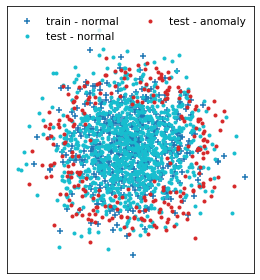

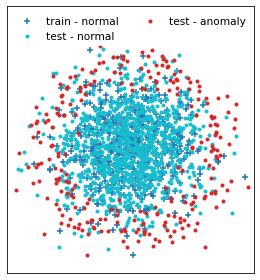

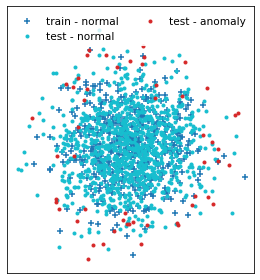

In [18]:
ratio_A = 0.2
f1_A, auc_A = plot_toy_dataset(ratio_A, hard_radius)

ratio_B = 0.2
f1_B, auc_B = plot_toy_dataset(ratio_B, easy_radius)

ratio_C = 0.05
f1_C, auc_C = plot_toy_dataset(ratio_C, easy_radius)

In [5]:
ratios = np.linspace(0.01, 0.5, 50)
print(f"Compute scores for easy dataset (radius {easy_radius})")
f1_easy, auc_easy = get_all_scores(easy_radius, ratios)
print(f"Compute scores for hard dataset (radius {hard_radius})")
f1_hard, auc_hard = get_all_scores(hard_radius, ratios)

f1_easy_m = np.mean(f1_easy, axis=1)
auc_easy_m = np.mean(auc_easy, axis=1)
f1_hard_m = np.mean(f1_hard, axis=1)
auc_hard_m = np.mean(auc_hard, axis=1)

f1_easy_s = np.std(f1_easy, axis=1)
auc_easy_s = np.std(auc_easy, axis=1)
f1_hard_s = np.std(f1_hard, axis=1)
auc_hard_s = np.std(auc_hard, axis=1)

# plt.figure(figsize=[8, 4.5])

# plt.plot(ratios*100,  auc_easy_m, label='AUC - Easy', color="tab:orange", zorder=2)
# plt.fill_between(ratios*100, auc_easy_m+auc_easy_s, auc_easy_m-auc_easy_s, alpha=0.3, color="tab:orange", zorder=2)

# plt.plot(ratios*100,  auc_hard_m, label='AUC - Hard', color="tab:red", zorder=2)
# plt.fill_between(ratios*100, auc_hard_m+auc_hard_s, auc_hard_m-auc_hard_s, alpha=0.3, color="tab:red", zorder=2)

# plt.plot(ratios*100,  f1_easy_m, label='F1_score - Easy', color="tab:cyan", zorder=2)
# plt.fill_between(ratios*100, f1_easy_m+f1_easy_s, f1_easy_m-f1_easy_s, alpha=0.3, color="tab:cyan", zorder=2)

# plt.plot(ratios*100,  f1_hard_m, label='F1_score - Hard', color="tab:blue", zorder=2)
# plt.fill_between(ratios*100, f1_hard_m+f1_hard_s, f1_hard_m-f1_hard_s, alpha=0.3, color="tab:blue", zorder=2)

# plt.scatter([ratio_A*100], [f1_A], marker='+', color="black", zorder=9)
# plt.annotate('(a)', xy=(ratio_A*100, auc_A), xytext=(ratio_A*100+1, f1_A-0.03), fontsize=12)

# plt.scatter([ratio_A*100], [auc_A], marker='+', color="black", zorder=9)
# plt.annotate('(a)', xy=(ratio_A*100, auc_A), xytext=(ratio_A*100+1, auc_A-0.03), fontsize=12)

# plt.scatter([ratio_B*100], [f1_B], marker='+', color="black", zorder=9)
# plt.annotate('(b)', xy=(ratio_B*100, auc_B), xytext=(ratio_B*100+1, f1_B-0.03), fontsize=12)

# plt.scatter([ratio_B*100], [auc_B], marker='+', color="black", zorder=9)
# plt.annotate('(b)', xy=(ratio_B*100, auc_B), xytext=(ratio_B*100+1, auc_B-0.03), fontsize=12)

# plt.scatter([ratio_C*100], [f1_C], marker='+', color="black", zorder=9)
# plt.annotate('(c)', xy=(ratio_C*100, auc_C), xytext=(ratio_C*100+1, f1_C-0.03), fontsize=12)

# plt.scatter([ratio_C*100], [auc_C], marker='+', color="black", zorder=9)
# plt.annotate('(c)', xy=(ratio_C*100, auc_C), xytext=(ratio_C*100+1, auc_C-0.03), fontsize=12)

# plt.ylim([0 ,1.0])
# plt.xlim([0, 50])
# plt.legend(loc='lower right', fontsize=12)
# plt.xlabel(f"contamination rate in test set (%)", fontsize=14)

# plt.tight_layout()
# plt.savefig(f"results/toy_example_easy_vs_hard_dataset."+img_format, format=img_format, dpi=dpi)
# plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

Compute scores for easy dataset (radius 2.5)


 11%|█         | 11/100 [00:04<00:37,  2.37it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/damien/.virtualenvs/anomaly/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-3c50d9e2cdd9>", line 3, in <module>
    f1_easy, auc_easy = get_all_scores(easy_radius, ratios)
  File "<ipython-input-2-45424c429de1>", line 83, in get_all_scores
    f1, auc = get_scores(X_train, X_test, y_test)
  File "<ipython-input-2-45424c429de1>", line 30, in get_scores
    clf.fit(X_train)
  File "/home/damien/.virtualenvs/anomaly/lib/python3.6/site-packages/sklearn/mixture/_base.py", line 193, in fit
    self.fit_predict(X, y)
  File "/home/damien/.virtualenvs/anomaly/lib/python3.6/site-packages/sklearn/mixture/_base.py", line 220, in fit_predict
    X = _check_X(X, self.n_components, ensure_min_samples=2)
  File "/home/damien/.virtualenvs/anomaly/lib/python3.6/site-packages/sklearn/mixture/_base.py", line 53, in _check_X
    ensure_min_sa

TypeError: object of type 'NoneType' has no len()

In [ ]:
plt.figure(figsize=[10,4])

# Add artificial plots for other figures
s1 = plt.scatter([], [], marker='+', color='tab:blue', label='train - normal')
s2 = plt.scatter([], [], marker='.', color='tab:cyan', label='test - normal')
s3 = plt.scatter([], [], marker='.', color='tab:red', label='test - anomaly')

p1, = plt.plot(ratios*100,  auc_easy_m, label='AUC - Easy', color="tab:orange", zorder=2)
plt.fill_between(ratios*100, auc_easy_m+auc_easy_s, auc_easy_m-auc_easy_s, alpha=0.3, color="tab:orange", zorder=2)

p2, = plt.plot(ratios*100,  auc_hard_m, label='AUC - Hard', color="tab:red", zorder=2)
plt.fill_between(ratios*100, auc_hard_m+auc_hard_s, auc_hard_m-auc_hard_s, alpha=0.3, color="tab:red", zorder=2)

p3, = plt.plot(ratios*100,  f1_easy_m, label='F1_score - Easy', color="tab:cyan", zorder=2)
plt.fill_between(ratios*100, f1_easy_m+f1_easy_s, f1_easy_m-f1_easy_s, alpha=0.3, color="tab:cyan", zorder=2)

p4, = plt.plot(ratios*100,  f1_hard_m, label='F1_score - Hard', color="tab:blue", zorder=2)
plt.fill_between(ratios*100, f1_hard_m+f1_hard_s, f1_hard_m-f1_hard_s, alpha=0.3, color="tab:blue", zorder=2)

plt.scatter([ratio_A*100], [f1_A], marker='+', color="black", zorder=9)
plt.annotate('(c)', xy=(ratio_A*100, auc_A), xytext=(ratio_A*100+1, f1_A-0.03), fontsize=12)

plt.scatter([ratio_A*100], [auc_A], marker='+', color="black", zorder=9)
plt.annotate('(c)', xy=(ratio_A*100, auc_A), xytext=(ratio_A*100+1, auc_A-0.03), fontsize=12)

plt.scatter([ratio_B*100], [f1_B], marker='+', color="black", zorder=9)
plt.annotate('(b)', xy=(ratio_B*100, auc_B), xytext=(ratio_B*100+1, f1_B-0.03), fontsize=12)

plt.scatter([ratio_B*100], [auc_B], marker='+', color="black", zorder=9)
plt.annotate('(b)', xy=(ratio_B*100, auc_B), xytext=(ratio_B*100+1, auc_B-0.03), fontsize=12)

plt.scatter([ratio_C*100], [f1_C], marker='+', color="black", zorder=9)
plt.annotate('(a)', xy=(ratio_C*100, auc_C), xytext=(ratio_C*100+1, f1_C-0.03), fontsize=12)

plt.scatter([ratio_C*100], [auc_C], marker='+', color="black", zorder=9)
plt.annotate('(a)', xy=(ratio_C*100, auc_C), xytext=(ratio_C*100+1, auc_C-0.03), fontsize=12)

plt.ylim([0 ,1.0])
plt.xlim([0, 50])

l1 = plt.legend(handles=[s1, s2, s3], bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=14)
l2 = plt.legend(handles=[p1, p2, p3, p4], bbox_to_anchor=(1.05, 0.5), loc='upper left', fontsize=14)
plt.gca().add_artist(l1)

# plt.legend(loc='lower right', fontsize=14)
plt.xlabel(f"contamination rate in test set (%)", fontsize=14)
plt.grid()
plt.tight_layout()
plt.savefig(f"results/toy_example_easy_vs_hard_dataset."+img_format, format=img_format, dpi=dpi)
plt.show()